<a href="https://colab.research.google.com/github/dnhshl/cc-ai/blob/main/FrozenLakeRL2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Frozen Lake - Einfaches Q-Learning Beispiel

Wir verwenden eine von openAI zur Verfügung gestellte Simulationsumgebung für Reinforcement Probleme (https://gym.openai.com/).

In [13]:
import gym

### FrozenLake (a Grid World)

Wir nutzen ein einfaches Beispiel: FrozenLake.
Problembeschreibung von OpenAI:

> *Winter is here. You and your friends were tossing around a frisbee at the park when you made a wild throw that left the frisbee out in the middle of the lake. The water is mostly frozen, but there are a few holes where the ice has melted. If you step into one of those holes, you'll fall into the freezing water. At this time, there's an international frisbee shortage, so it's absolutely imperative that you navigate across the lake and retrieve the disc. However, the ice is slippery, so you won't always move in the direction you intend.*


<img src="https://zitaoshen.rbind.io/project/rl/1-min-of-reinforcement-learning-q-learning/featured.png?raw=1" alt="FrozenLake" style="width: 400px;"/>

Wir starten in der linken oberen Ecke (S). Unser Ziel ist es, zur unteren rechten Ecke (G) zu gelangen, ohne zwischendurch in ein Loch (H) zu fallen.

Es gibt vier mögliche Aktionen:

0=links, 1=runter, 2=rechts, 3=rauf

Die Stati sind die 16 Felder (0 .. 15).


Jede Bewegung führt dazu, dass sich der Status des Agenten von $s_t$ zu $s_{t+1}$ ändert, wenn er seinen Standort ändert, es sei denn, er versucht, sich in Richtung einer Wand zu bewegen, was dazu führt, dass sich der Status des Agenten nicht ändert (der Agent bewegt sich nicht).
Für das Erreichen des Ziels (G) erhalten wir eine positive Belohnung von „+1“, die je nach Dauer abgezinst wird.
Obwohl es keine negative Belohnung für das Fallen in ein Loch gibt (H), zahlt der Agent dennoch eine Strafe in dem Sinne, dass das Fallen in das Loch die Episode beendet und ihn daher daran hindert, eine Belohnung zu erhalten.
Wir wollen eine Richtlinie $\pi$ lernen, die uns in möglichst wenigen Schritten von unserem Startort (S) zum Ziel (G) führt.

Das Problem ist schwieriger, als es sich für uns in der ersten Betrachtung darstellt:

- **Kenntnis der Zustände und Übergangswahrscheinlichkeiten:** Aus der globalen Sicht von oben könnte der erste Gedanke sein, einen Weg vom Start bis zum Ziel zu planen, genau wie bei einem Labyrinth.
Diese Ansicht wird uns jedoch den Algorithmus-Designern zur Verfügung gestellt, damit wir das vorliegende Problem visualisieren können.
Der Agent, der die Aufgabe lernt, erhält dieses Vorwissen *nicht*; Alles was wir sagen werden ist, dass es 16 Stati und 4 mögliche Aktionen in jedem Status gibt.
Eine passendere Analogie wäre:  Sie stehen mit verbundenen Augen auf einem zugeforenen See. Jedes mal, wenn Sie sich entscheiden, einen Schritt in eine von vier Richtungen zu machen, wird Ihnen Ihr neuer Zustand (Standort) mitgeteilt. Finden Sie das Frisbee, ohne ins Eis einzubrechen, erhalten Sie eine Belohnung, die umso größer ist, je schneller Sie das Frisbee finden.

- **Kenntnis des Ziels (Belohnung):**
Der Agent weiß  *nicht*, was das Ziel ist.
Vielmehr lernen Sie das Ziel, indem es Belohnungen (oder Strafen) gibt, und der Algorithmus aktualisiert seine Richtlinie zur Wahl von Aktionen so, dass er Aktionen mit größerer Wahrscheinlichkeit erneut durchführt, die voraussichtlich zu einer späteren Belohnung führen.
Beachten Sie, dass dies bedeutet, dass ein Agent, wenn er bestimmte Belohnungen nie erhält, nicht weiß, dass sie existieren.

- **Vorkenntnisse in Pfadfindung, Physik, etc.:** Als Mensch bringen Sie, auch wenn Sie diese Aufgabe noch nicht gelöst haben, enorme Vorkenntnisse zu diesem Problem mit.
Sie wissen beispielsweise, dass der kürzeste Weg zu einem Ziel eine Linie ist.
Sie wissen, dass Norden, Süden, Osten und Westen Richtungen sind und dass Sie nach Norden und dann nach Süden zurückkehren, wo Sie bereits waren.
Sie wissen, dass Eis rutschig ist.
Sie wissen, dass eisiges Wasser kalt ist.
Sie wissen, dass es schlecht ist, in eiskaltem Wasser zu sein.
Der Agent weiß von all diesen Dingen nichts; seine anfängliche Richtlinie besteht im Wesentlichen darin, Aktionen vollständig zufällig auszuwählen.
Am Ende des Trainings wird es immer noch nicht wissen, was abstrakte Konzepte wie "Nord/Süd", "kalt" oder "rutschig" bedeuten, aber es wird (hoffentlich) eine gute Politik gelernt haben, die es ihm ermöglicht, das Ziel zu erreichen.


In [28]:
env1 = gym.make('FrozenLake-v1', render_mode='ansi')
env=env1
print(env.observation_space, env.action_space)

Discrete(16) Discrete(4)


Über einen `reset() `kann das Environment jeweils "auf Start" zurückgesetzt werden. Der Status $s$ wird dann also 0 (das erste Feld) sein.


In [49]:
s = env.reset()
print(s)

0


Mittels `render()` kann der aktuelle Status dargestellt werden.


In [50]:
for e in env.render():
  print(e)




SFFF
FHFH
FFFH
HFFG



Die Standard FrozenLake-Umgebung ist "rutschig". Wegen des Eises haben Sie, wenn Sie versuchen, in eine Richtung zu gehen, eine 1/3-Chance, in die von Ihnen gemeinte Richtung und die beiden angrenzenden Richtungen zu gehen. Wenn wir zum Beispiel versuchen, nach rechts zu gehen, haben wir die gleiche Wahrscheinlichkeit, stattdessen abzurutschen und nach oben und unten zu gehen. Dies macht die Sache etwas komplizierter.

Wir definieren uns zunächst eine "nicht rutschige" Umgebung, in der die Aktion deterministisch ausgeführt wird.


In [51]:
# Non-slippery version

from gym.envs.registration import register
register(
    id='FrozenLakeNotSlippery-v1',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 'is_slippery': False},
)


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:542: UserWarning: WARN: Overriding environment FrozenLakeNotSlippery-v1
  logger.warn(f"Overriding environment {spec.id}")


In [52]:
env2 = gym.make('FrozenLakeNotSlippery-v1', render_mode='ansi')
env=env2

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Mittels `step(action)` führen wir einen Schritt durch.
`step(2)` entspricht also einer Bewegung nach rechts.
Beachten Sie, dass die Ausgabe ein Tupel von vier Elementen ist: der nächste Statusg (`object`), der reward (`float`), ob die Episode fertig ist (`boolean`) und weitere Infos (`dict` ), die für das Debuggen nützlich sein können.

In [53]:
env.reset()
for e in env.render():
  print(e)
env.step(2)
for e in env.render():
  print(e)



SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG



Sobald wir in einem Loch (H) oder im Ziel (G) gelandet sind, ist die Episode beendet. Weitere Aktionen können dann nicht mehr durchgeführt werden.

Wir können zunächst Aktionen einfach einmal zufällig auswählen.

In [54]:
env.reset()
done = False

while not done:
    for e in env.render():
      print(e)
    action = env.action_space.sample()
    _, _, done, _ = env.step(action)
for e in env.render():
  print(e)


SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG





### Q-learning in FrozenLake
FrozenLake ist eine sehr einfache Problemstellung.

Mit nur 16 Zuständen und 4 Aktionen sind nur 64 Zustands-Aktions-Paare möglich. Unsere Q-Tabelle ist alsa 16x4. Wir initialisieren die Q Tabelle mit Nullen.

In [55]:
import numpy as np

#Initialize table with all zeros to be uniform
Q = np.zeros([env.observation_space.n, env.action_space.n])
print(Q)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


#### Trainingsparameter

In [56]:
# Learning parameters
alpha = 0.1
gamma = 0.95
num_episodes = 2000

# array of reward for each episode
rs = np.zeros([num_episodes])

#### Training

In [57]:
for i in range(num_episodes):
    # Set total reward and time to zero, done to False
    r_sum_i = 0
    t = 0
    done = False

    #Reset environment and get first new observation
    s = env.reset()

    while not done:
        # Choose an action by greedily (with noise) from Q table
        a = np.argmax(Q[s,:] + np.random.randn(1, env.action_space.n)*(1./(i/10+1)))

        # Get new state and reward from environment
        s1, r, done, _ = env.step(a)

        # Update Q-Table with new knowledge
        Q[s,a] = (1 - alpha)*Q[s,a] + alpha*(r + gamma*np.max(Q[s1,:]))

        # Add reward to episode total
        r_sum_i += r*gamma**t

        # Update state and time
        s = s1
        t += 1
    rs[i] = r_sum_i

Wie entwickelt sich der Reward im Verlaufe der Episoden?

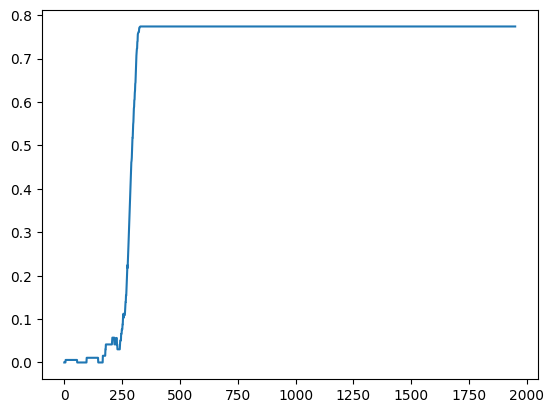

In [58]:
## Plot reward vs episodes
import matplotlib.pyplot as plt

# Sliding window average
r_cumsum = np.cumsum(np.insert(rs, 0, 0))
r_cumsum = (r_cumsum[50:] - r_cumsum[:-50]) / 50

# Plot
plt.plot(r_cumsum)
plt.show()

Wie oft hat unser Agent das Ziel tatsächlich erreicht?
Dies erklärt nicht, wie schnell der Agent dort ankam (was auch von Interesse sein könnte), aber wir ignorieren dass.
Wir teilen die 2000 Episoden in 10 Buckets a 200 und schauen, wie oft jeweils das Ziel erreicht wurde.

In [59]:
# Print number of times the goal was reached
N = len(rs)//10
num_Gs = np.zeros(10)

for i in range(10):
    num_Gs[i] = np.sum(rs[i*N:(i+1)*N] > 0)

print("Rewards: {0}".format(num_Gs))

Rewards: [  2. 100. 200. 200. 200. 200. 200. 200. 200. 200.]


Welche (deterministische) Route nimmt unser Agent?

In [67]:
def perform_and_render():

  s = env.reset()
  done = False

  while not done:

    for e in env.render():
      print(e)
    action = np.argmax(Q[s,:])
    print(action)
    s, _, done, _ = env.step(action)
  for e in env.render():
    print(e)

In [68]:
perform_and_render()



SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

3
  (Up)
SFFF
FHFH
FFFH
HFFG

1
  (Down)
SFFF
FHFH
FFFH
HFFG

3
  (Up)
SFFF
FHFH
FFFH
HFFG

3
  (Up)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

3
  (Up)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

3
  (Up)
SFFF
FHFH
FFFH
HFFG

3
  (Up)
SFFF
FHFH
FFFH
HFFG

1
  (Down)
SFFF
FHFH
FFFH
HFFG

3
  (Up)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

3
  (Up)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

3
  (Up)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

3
  (Up)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

0
  (L

Nutzen wir nun die Originalumgebung mit der Wahrscheinlichkeit, "auszurutschen".

In [64]:
env = env1

Nachdem wir jetzt das Environment zurückgesetzt haben, können wir in dieser Umgebung trainieren.

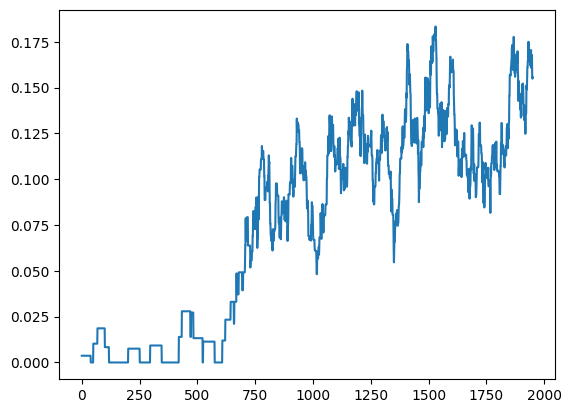

Rewards: [ 3.  2.  4. 15. 75. 79. 72. 86. 89. 84.]


In [65]:

#Initialize table with all zeros to be uniform
Q = np.zeros([env.observation_space.n, env.action_space.n])

# Learning parameters
alpha = 0.1
gamma = 0.95
num_episodes = 2000

# array of reward for each episode
rs = np.zeros([num_episodes])

for i in range(num_episodes):
    # Set total reward and time to zero, done to False
    r_sum_i = 0
    t = 0
    done = False

    #Reset environment and get first new observation
    s = env.reset()

    while not done:
        # Choose an action by greedily (with noise) from Q table
        a = np.argmax(Q[s,:] + np.random.randn(1, env.action_space.n)*(1./(i/10+1)))

        # Get new state and reward from environment
        s1, r, done, _ = env.step(a)

        # Update Q-Table with new knowledge
        Q[s,a] = (1 - alpha)*Q[s,a] + alpha*(r + gamma*np.max(Q[s1,:]))

        # Add reward to episode total
        r_sum_i += r*gamma**t

        # Update state and time
        s = s1
        t += 1
    rs[i] = r_sum_i

## Plot reward vs episodes
# Sliding window average
r_cumsum = np.cumsum(np.insert(rs, 0, 0))
r_cumsum = (r_cumsum[50:] - r_cumsum[:-50]) / 50

# Plot
plt.plot(r_cumsum)
plt.show()

# Print number of times the goal was reached
N = len(rs)//10
num_Gs = np.zeros(10)

for i in range(10):
    num_Gs[i] = np.sum(rs[i*N:(i+1)*N] > 0)

print("Rewards: {0}".format(num_Gs))

In [72]:
perform_and_render()


SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

0
  (Left)
SFFF
FHFH
FFFH
HFFG

3
  (Up)
SFFF
FHFH
FFFH
HFFG

1
  (Down)
SFFF
FHFH
FFFH
HFFG

1
  (Down)
SFFF
FHFH
FFFH
HFFG

1
  (Down)
SFFF
FHFH
FFFH
HFFG

3
  (Up)
SFFF
FHFH
F